## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

### Setup

In [1]:
import os
import yaml
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import preprocess, train, inference, interpret

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
with open("params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

### Load and Prepare the Data

In [3]:
file_name = "ev_df.csv"
data = preprocess.load_data(file_name)
data.head(3)

,ITL level 3,Year,Quarter,gdhi,ITL level 1,ITL level 2,Average variable unit price (£/kWh),ULSP: Pump price (p/litre),ULSD: Pump price (p/litre),Sum of Chargepoints,NQF level 4 or above,NQF level 3 or above,NQF level 2 or above,latitude,longitude,population,Number of vehicles,Number of car models
0,Aberdeen City and Aberdeenshire,2010,1,18736.0,Scotland,North Eastern Scotland,0.117261,116.904146,119.234615,0,37,58,77,57.221773,-2.199011,2588.791209,0.0,2.0
1,Aberdeen City and Aberdeenshire,2011,1,19637.0,Scotland,North Eastern Scotland,0.121785,133.412774,138.805382,0,38,59,78,57.221773,-2.199011,2615.989011,0.0,4.0
2,Aberdeen City and Aberdeenshire,2012,1,20350.0,Scotland,North Eastern Scotland,0.127916,135.761462,142.171851,0,42,65,82,57.221773,-2.199011,2639.945055,0.0,6.0


In [4]:
train_df, test_df = preprocess.prep_data(df=data, train_frac=0.8, plot_df=True)

Starting with data preparation...
Completed.


In [5]:
train_df.shape, test_df.shape

((5273, 14), (1319, 14))

### Explore the Data

In [6]:
plot_df = pd.read_csv(Path(data_dir, 'plot_df.csv'))
plot_df = plot_df.dropna()

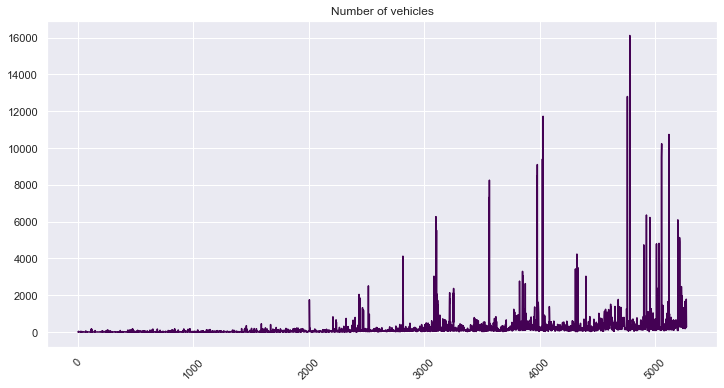

In [7]:
plot_df['Number of vehicles'].plot(figsize=(12,6), rot=45, cmap='viridis')
plt.title('Number of vehicles')
plt.show()

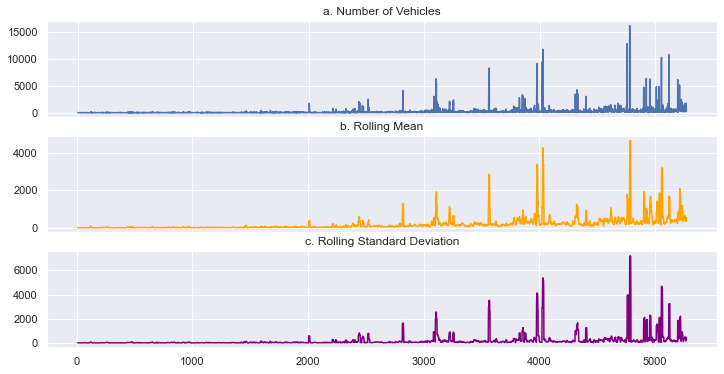

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1)
plot_df['Number of vehicles'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Number of Vehicles', sharex=True)
plot_df['Number of vehicles'].rolling(10).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
plot_df['Number of vehicles'].rolling(10).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

### Train the LSTM model

In [9]:
sequence_length = 30
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
label_name = 'Number of vehicles'

In [10]:
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

Starting with model training...
Epoch 1 train loss: 0.0022 test loss: 0.0173
Epoch 2 train loss: 0.0021 test loss: 0.0172
Epoch 3 train loss: 0.002 test loss: 0.0169
Epoch 4 train loss: 0.002 test loss: 0.0162
Epoch 5 train loss: 0.0019 test loss: 0.015
Epoch 6 train loss: 0.0019 test loss: 0.0147
Epoch 7 train loss: 0.0018 test loss: 0.0146
Epoch 8 train loss: 0.0018 test loss: 0.0157
Epoch 9 train loss: 0.0016 test loss: 0.0139
Epoch 10 train loss: 0.0017 test loss: 0.0143
Epoch 11 train loss: 0.0017 test loss: 0.0147
Epoch 12 train loss: 0.0016 test loss: 0.0143
Epoch 13 train loss: 0.0017 test loss: 0.0137
Epoch 14 train loss: 0.0016 test loss: 0.0143
Epoch 15 train loss: 0.0015 test loss: 0.0141
Epoch 16 train loss: 0.0016 test loss: 0.0143
Epoch 17 train loss: 0.0015 test loss: 0.0142
Early stopping.
Completed.


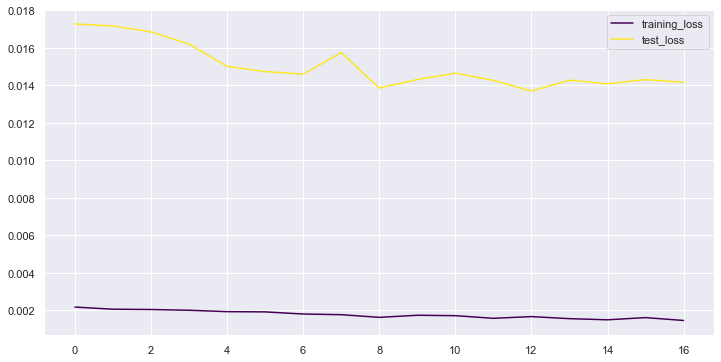

In [11]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [12]:
predictions_descaled, labels_descaled = inference.predict(df=test_df,
                                                          label_name='Number of vehicles',
                                                          sequence_length=sequence_length)

labels_descaled.shape, predictions_descaled.shape

((1289,), (1289,))

In [13]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

Error on all test data:
RMSE:  1.05
MAE:  0.4


Error on partial test data:
RMSE:  0.2
MAE:  0.19


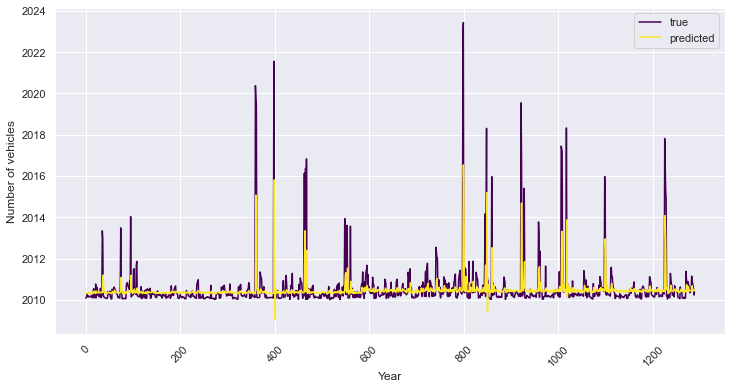

In [14]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['true'] = labels_descaled
df_pred['predicted'] = predictions_descaled
#df_pred['residual'] = labels_descaled - predictions_descaled
df_pred.plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.ylabel('Number of vehicles')
plt.xlabel('Year')
plt.legend()
plt.show()

### Find important features

In [15]:
from train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [16]:
background_data_size = 900
test_sample_size = 100
sequence_length = 40

In [17]:
shap_values = interpret.get_important_features(
    background_data_size,
    test_sample_size,
    sequence_length
)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [18]:
shap_plot = pd.DataFrame(shap_values, columns=train_df.columns.tolist())
years = list(range(2010, 2020))
quarters = [1, 2, 3, 4]

# Create an empty DataFrame to store the results
shap_plot_new = pd.DataFrame()

# Use nested loops to iterate through years and quarters
for year in years:
    for quarter in quarters:
        # Create a new row with the current 'Year' and 'Quarter' in the desired format
        new_row = {'Year': f"{year} Q{quarter}"}
        # Append the row to the DataFrame
        shap_plot_new = shap_plot_new.append(new_row, ignore_index=True)
shap_plot['Year'] = shap_plot_new['Year']
shap_plot

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

,Year,Number of vehicles,population,Average variable unit price (£/kWh),Sum of Chargepoints,ULSP: Pump price (p/litre),ULSD: Pump price (p/litre),NQF level 4 or above,Quarter,NQF level 3 or above,NQF level 2 or above,latitude,longitude,Number of car models
0,2010 Q1,5.002565e-11,3.779310e-12,3.695517e-12,2.498209e-12,1.776346e-11,3.161977e-12,9.187500e-12,7.036576e-12,1.507862e-11,1.652739e-11,3.876890e-12,5.247388e-12,6.549283e-11
1,2010 Q2,3.228870e-11,2.739509e-11,4.318559e-11,5.028458e-12,7.812215e-12,3.060096e-11,2.429116e-11,5.036011e-12,1.669720e-11,9.313232e-13,1.207906e-12,2.377971e-12,9.898987e-13
2,2010 Q3,1.068919e-10,1.548748e-11,1.025676e-10,1.162623e-11,2.018166e-11,2.295274e-11,7.483716e-11,2.184916e-11,1.301896e-11,4.304630e-11,9.152308e-12,1.115284e-11,2.970809e-10
3,2010 Q4,1.955757e-10,1.023932e-10,2.287357e-11,3.352847e-12,1.698064e-11,4.257480e-11,2.717592e-11,8.217770e-11,3.523614e-11,5.376608e-11,8.055744e-12,1.224062e-11,3.863435e-10
4,2011 Q1,1.353885e-10,1.180959e-10,1.467790e-10,3.204402e-11,1.920781e-12,9.389411e-11,1.380018e-10,3.062236e-11,1.467200e-11,4.639388e-11,1.876198e-11,2.345736e-11,3.431903e-10
5,2011 Q2,5.745337e-10,1.296922e-10,9.278608e-11,1.375860e-11,2.889557e-11,5.285945e-11,1.238990e-10,1.269433e-10,1.033944e-10,1.425035e-10,3.407000e-11,4.918499e-11,9.560903e-10
6,2011 Q3,6.855180e-11,3.440110e-10,2.973563e-10,6.025228e-11,1.146077e-11,7.595015e-11,2.205524e-10,1.373111e-10,5.585515e-11,1.708087e-11,1.968450e-11,1.231724e-11,1.019284e-10
7,2011 Q4,1.250147e-09,5.564393e-11,4.609879e-10,7.297577e-11,2.623572e-10,2.729581e-10,4.551294e-10,1.855384e-10,1.654855e-10,2.751173e-10,8.300682e-11,1.115612e-10,2.270084e-09
8,2012 Q1,9.750814e-10,8.036553e-10,2.362507e-10,8.135675e-11,1.978757e-10,3.006594e-10,1.253340e-10,4.566397e-10,2.127329e-10,2.760510e-10,3.348370e-11,4.647708e-11,1.482145e-09
9,2012 Q2,1.963620e-09,4.299806e-10,1.000516e-09,2.073817e-10,8.695354e-10,5.431678e-10,9.744269e-10,5.810021e-11,1.890230e-10,2.741535e-10,1.949933e-10,2.119285e-10,3.504050e-09


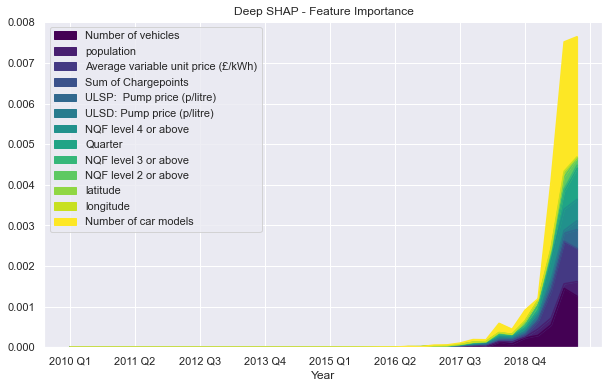

In [19]:
shap_plot.plot.area(x='Year',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()

## Important Features

Understanding why the model makes the predictions it makes can be difficult in the case of neural networks. We use an approach that is based on the DeepLIFT algorithm which approximates the SHAP values known from classic game theory. Basically, this approach seeks to answer the question of how much a feature contributes to a model’s predictions when it’s there (in the inputs) compared to when it’s not there (not in the inputs), thus deriving the feature’s importance. More specifically, the method decomposes the output prediction of a neural network on a specific input by backpropagating the contributions of all neurons in the network to every feature of the input. It then compares the activation of each neuron to its reference activation and assigns contribution scores (or multipliers) according to the difference. The reference input represents some default or neutral input that is chosen depending on the domain, e.g., zeros or feature averages. Once the multipliers have been computed based on a representative dataset (or background dataset), we can calculate the contributions of the input features to the model’s output based on some sample inputs and rank the features in order of their largest contributions to get their importance.
We use 900 training data samples as the background dataset and 100 test data samples on which to explain the model’s output. Since the feature importances are calculated for each input sample at each time step, we average them across all 100 input samples and plot the importances by feature as well as by time step. The top input features are gdhi, number of vehicles, population, and the unit price. We can also see that more recent time steps, 2016 Q2 to 2020Q4, play a more significant role in making predictions compared to time steps further away.

Important Features based on Deep SHAP
Understanding a deep learning model’s predictions can be essential in reducing the barriers to adoption in applications where interpretability is needed. In addition to predicting an outcome with a certain accuracy, we can now measure its most important contributors. For example, were we to predict a company’s product sales, by applying this feature importance technique we could gain additional insight into why sales are changing and device action plans to promote a desired business outcome (e.g. to increase sales by favoring a particular marketing campaign that contributes to higher sales).
Furthermore, the insights from finding the important features can also help inform the model optimization process. For example, here, the car models, spatial quantities and education levels don't seem as significant to the model so they can be removed.